In [1]:
import numpy as np
np.random.seed(13)
from keras.models import Sequential
from keras.layers import Embedding, Merge, Reshape, Activation
from keras.utils import np_utils
from keras.utils.data_utils import get_file
from keras.utils.visualize_util import model_to_dot, plot
from keras.preprocessing.text import Tokenizer, base_filter
from keras.preprocessing.sequence import skipgrams

from gensim.models.doc2vec import Word2Vec
from IPython.display import SVG, display

Using Theano backend.


In [2]:
path = get_file('alice.txt', origin="http://www.gutenberg.org/cache/epub/11/pg11.txt")
corpus = open(path).readlines()

corpus = [sentence for sentence in corpus if sentence.count(" ") >= 2]
tokenizer = Tokenizer(filters=base_filter()+"'")
tokenizer.fit_on_texts(corpus)
V = len(tokenizer.word_index) + 1
V

3032

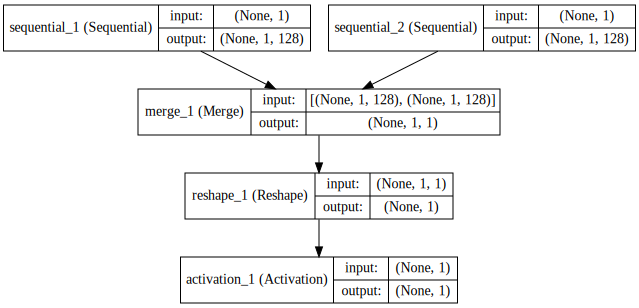

In [3]:
dim_embedddings = 128

# inputs
inputs = Sequential()
inputs.add(Embedding(V, dim_embedddings, input_length=1))

# context
context = Sequential()
context.add(Embedding(V, dim_embedddings, input_length=1))

model = Sequential()
model.add(Merge([inputs, context], mode='dot', dot_axes=2))
model.add(Reshape((1,), input_shape=(1,1)))
model.add(Activation('sigmoid'))
model.compile(loss="binary_crossentropy", optimizer="rmsprop")
display(SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg')))

In [4]:
for _ in range(30):
    loss = 0.
    for doc in tokenizer.texts_to_sequences(corpus):        
        data, labels = skipgrams(sequence=doc, vocabulary_size=V, window_size=5, negative_samples=5.)
        X = [np.array(x) for x in zip(*data)]
        Y = np.array(labels, dtype=np.int32)
        if X:
            loss += model.train_on_batch(X, Y)
    print(loss)


1212.13172601
864.496609695
798.478040159
769.374685228
751.196461126
741.106172118
735.174817093
728.562292472
722.202479899
717.078176275
713.063365672
708.66620351
704.449001189
702.908395443
698.81142877
695.062582567
690.317170605
687.782671351
683.620384663
680.519070435
676.811206356
673.595114462
670.116418805
665.013225578
662.628947984
658.544185497
653.804591347
651.289514737
648.118846636
645.559887867


In [5]:
f = open('vectors.txt' ,'w')
f.write(" ".join([str(V-1),str(dim_embedddings)]))
f.write("\n")

1

In [6]:
vectors = model.get_weights()[0]
for word, i in tokenizer.word_index.items():
    f.write(word)
    f.write(" ")
    f.write(" ".join(map(str, list(vectors[i,:]))))
    f.write("\n")
f.close()

In [7]:
w2v = Word2Vec.load_word2vec_format('./vectors.txt', binary=False)

In [8]:
w2v.most_similar(positive=['queen'])

[('hearts', 0.5008265972137451),
 ('king', 0.4858705699443817),
 ('soldiers', 0.47791656851768494),
 ('white', 0.47445476055145264),
 ('looking', 0.4524249732494354),
 ('top', 0.43395373225212097),
 ('jury', 0.39905229210853577),
 ('gardeners', 0.3968312740325928),
 ('left', 0.3948673903942108),
 ('guests', 0.3779906630516052)]

In [9]:
w2v.most_similar(positive=['alice'])

[('said', 0.5025979280471802),
 ('but', 0.47889235615730286),
 ('yet', 0.4665682911872864),
 ('i', 0.44512903690338135),
 ('very', 0.429546982049942),
 ('never', 0.41930341720581055),
 ('as', 0.417292058467865),
 ('come', 0.4021140933036804),
 ('hastily', 0.392463743686676),
 ('thought', 0.3823994994163513)]

In [10]:
w2v.most_similar(positive=['the'])

[('of', 0.45146051049232483),
 ('and', 0.43136486411094666),
 ('a', 0.39306485652923584),
 ('to', 0.39201533794403076),
 ('in', 0.3618614077568054),
 ('that', 0.30804580450057983),
 ('went', 0.3013942837715149),
 ('s', 0.29263943433761597),
 ('said', 0.2897889316082001),
 ('came', 0.2856040894985199)]